# Assignment 3.4 - Clustering

**Name**: Avneesh Mishra <br>
**Roll No**: 2021701032


In [1]:
# Import everything
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from tensorflow import keras
from sklearn.manifold import TSNE

---

# Part 1: K-Means on Fashion-MNIST dataset

1. Load the dataset and implement k-Means algorithm (from scratch). You need to find the optimal number of clusters using

    - Elbow Method
    - Silhouette analysis

2. Define the initial clusters’ centroids using

    - Forgy
    - Random Partition

3. Experiment with different distance measures (Euclidean distance, Manhattan distance)

4. Plot the error vs number of clusters graph while using the elbow method and silhouette analysis. Report the optimal number of clusters found.

5. Visualize the dataset to depict the clusters formed. (prefer T-SNE)

## Section 1.1: Load Fashion-MNIST and k-Means implementation

Imports all data and implements the kMeans algorithm. This completes the following goals

1. Implementing the KMeans algorithm from scratch
    1. Initial cluster centroids using `Forgy` and `Random Partition`
    2. Distance measures: `Manhattan` and `Euclidean`

In [2]:
# Load the dataset
(img_train, label_train), (img_test, label_test) = keras.datasets.\
    fashion_mnist.load_data()
# Using the test set (compute constraints) for clustering
x_data = img_test.reshape(-1, 28*28)   # 10000, 784
y_data = label_test     # 10000,
# Training set (small for testing the implementations)
x_train = x_data[:500, :]
y_train = y_data[:500]

In [3]:
# KMeans from scratch
class KMeans:

  @staticmethod
  def euclidean_dist(x1, x2):
    return np.linalg.norm(x1-x2)
  
  @staticmethod
  def manhat_dist(x1, x2):
    return np.sum(np.abs(x1-x2))

  # Constructor
  def __init__(self, k=10, dist_m = "eu", init_m = "fg"):
    """
      k: int  default: 10
      dist_m: {"eu", "mt"}
      init_m: {"fg", "rp"}  Forgy or Random Partition
    """
    # K value
    self.k = k
    # Initialization Method
    self.im = init_m
    # Distance metric
    self.dm = KMeans.euclidean_dist if dist_m == "eu" else \
      KMeans.manhat_dist
    # Cluster centers (as list)
    self.cs = None
    # Data
    self.x = None
  
  # Fit the data
  def fit(self, x_train: np.ndarray, max_iter = 300, db_out = True):
    """
      returns cga: Array of cluster group numbers, one for each x
    """
    self.x = x_train  # Backup. Do not modify
    self.cx = self.x.copy() # Can modify
    # Initialize the cluster centers
    if self.im == "fg": # Forgy initialization
      self.icc_forgy()
      pass
    else: # Random partition initialization
      self.icc_rp()
    # Cluster centers have been initialized. Start KMeans
    for i in range(max_iter):
      # Assign each point to a cluster center (based on distance)
      cga = self.get_cga()
      # Get the new cluster centers
      ncc = self.update_cs(cga)
      # Check if they're changing
      if np.allclose(ncc, self.cs):
        if db_out:  # Debug output
          print(f"[Iter {i}]: Cluster centers stagnated")
        break   # Can't change anything
      else:
        self.cs = ncc # New cluster centers calculated
    return cga
  
  # Initial Cluster Center: Forgy initialization
  def icc_forgy(self):
    # Select 'k' random data items as cluster centers
    cs_i = np.random.randint(0, self.x.shape[0], self.k)
    self.cs = self.x[cs_i]  # Cluster centers initialized
  
  # Random initialization
  def icc_rp(self):
    # Random group assignment
    i = np.random.randint(0, self.k, self.x.shape[0]) # Group index
    # For every group, find the cluster center
    self.cs = []
    for g in range(self.k):
      self.cs.append(np.mean(self.x[i==g], axis=0))
    self.cs = np.array(self.cs)
  
  # Get the cluster each point belongs to (cluster group array)
  def get_cga(self):
    # Calculate the distance matrix
    dist_mat = np.array([[self.dm(x, c) for c in self.cs] 
      for x in self.x])
    # New cluster center indices
    nccis = np.argmin(dist_mat, axis=1)
    return nccis
  
  # Update cluster centers based on new cluster groups
  def update_cs(self, cga):
    # For every group, find the cluster center
    ncc = []  # New Cluster Centers
    for i in range(self.k):
      ncc.append(np.mean(self.x[cga == i], axis=0))
    ncc = np.array(ncc)
    return ncc

Example usage

In [4]:
km_clf = KMeans(init_m="rp", dist_m="mt")

In [5]:
cga = km_clf.fit(x_train)

[Iter 10]: Cluster centers stagnated


## Section 1.2: Elbow and Silhouette Method

Finding the optimal number of clusters using the two methods. This completes the following goals

1. Plot error vs. number of clusters graph while using `elbow method` and perform the `silhouette analysis`. Report the optimal number of clusters found.
2. Experiment with _different distance measures_ (this is included in the report and code).


### Elbow Method

Sum of squared (or absolute too works) distance of the data-points from the cluster centers has to be plotted (versus the number of clusters)


In [6]:
def elbow_vals(x_train, k_max = 15, dm = "eu", init_m = "fg"):
    """
        dm: {"eu", "mt"}
        init_m: {"fg", "rp"}  Forgy or Random Partition
    """
    dist_m = KMeans.euclidean_dist if dm == "eu" \
        else KMeans.manhat_dist
    # Calculate the sum of distances
    def sd_calc(x_v, cga, ccs):
        total_d = 0
        for i in range(ccs.shape[0]):
            total_d += np.sum([dist_m(x, ccs[i])\
                for x in x_v[cga == i]])
        return total_d
    # Array to return
    sd_vals = []    # Sum of distances
    # Perform KMeans for every k (2 to k)
    for k in range(2, k_max+1):
        # KMeans
        km_c = KMeans(k, dist_m=dm, init_m=init_m)
        # Get the fit
        cga = km_c.fit(x_train, db_out= False)
        # Get SD
        sd_vals.append(sd_calc(x_train, cga, km_c.cs))
    sd_vals = np.array(sd_vals, float)
    return sd_vals

In [7]:
# Get values through elbow method
k_max = 20
sd_vals = elbow_vals(x_train, k_max)

C:\Users\123av\.conda\envs\smai-cs7-403\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\123av\.conda\envs\smai-cs7-403\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


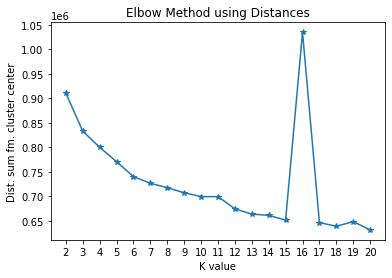

In [8]:
# Show the elbow curves
plt.figure()
plt.title("Elbow Method using Distances")
plt.plot(np.arange(2, k_max+1), sd_vals, '*-')
plt.xticks(np.arange(2, k_max+1))
plt.xlabel("K value")
plt.ylabel("Dist. sum fm. cluster center")
plt.show()

According to the above plot, if we use the default metrics for the `elbow` method function, we get `k=8` as the desired number of clusters. This is because `k=8` is the point after which the SD curves nearly becomes a straight line (after removing the outliers). The curve is shown below (for Euclidean distance)

<img src="./figures/elbow_eu.png" alt="Elbow curve for Euclidean distance" width=450 style="background-color: #ffffff" />

However, if Manhattan distance is used (which was found to be more numerically stable), then the `k` value was found to be `k=10`. The plot is shown below.

<img src="./figures/elbow_mt.png" alt="Elbow curve for Manhattan distance" width=450 style="background-color: #ffffff" />

### Silhouette Analysis

The Silhouette analysis of the clustering involves comparing the average distance of points intra-cluster with the points inter-cluster


In [17]:
# Implement silhouette method from scratch
def silhouette_vals(x_train, k_vals, dm = "eu", init_m = "fg"):
    """
        dm: {"eu", "mt"}
        init_m: {"fg", "rp"}  Forgy or Random Partition
    """
    dist_m = KMeans.euclidean_dist if dm == "eu" \
        else KMeans.manhat_dist
    # Silhouette score for each sample and the mean silhouette coeff.
    def silhouette_samples(cga, k_val):
        a_i = np.zeros(x_train.shape[0], float) # Intra-cluster
        b_i = np.zeros(x_train.shape[0], float) # Inter-cluster
        s_i = np.zeros(x_train.shape[0], float) # Sil. coeffs.
        # For each datapoint
        for i in range(x_train.shape[0]):
            c_i = cga[i]    # Cluster of 'i'th sample
            num_ci = np.sum(cga == c_i)
            if num_ci <= 1: # Too few samples
                continue
            # Intra-cluster
            a_i[i] = (1/(num_ci-1)) * np.sum([dist_m(x, x_train[i])
                for x in x_train[cga == c_i]])
            # Inter-cluster
            b_k_avg = []
            for ck in range(k_val):
                if ck == c_i:   # Don't use same cluster
                    continue
                # Get avg. dist. of 'i' from points in 'ck' cluster
                num_ck = np.sum(cga == ck)
                if num_ck == 0: # No use of considering the null case
                    continue
                b_k_avg.append((1/num_ck)*np.sum([
                    dist_m(x_train[i], x) for x in x_train[cga == ck]]
                    ))
            b_i[i] = np.min(b_k_avg)
            if num_ci > 1: # No use of considering this cluster
                s_i[i] = (b_i[i] - a_i[i]) / max(a_i[i], b_i[i])
        return s_i, np.mean(s_i)
    sil_avgs = []   # Accumulate averages
    sil_scores_arr = [] # All scores
    # For all k values
    for k in k_vals:
        # Get clustering result
        km_c = KMeans(k, dm, init_m)
        cga = km_c.fit(x_train, db_out=False)
        # Get the sample scores and avg. score
        sil_scores, sil_avg = silhouette_samples(cga, k)
        sil_avgs.append(sil_avg)
        sil_scores_arr.append(sil_scores)
        # Figure
        fig = plt.figure(figsize=(4.8, 6.4))
        ax = fig.add_subplot()
        ax.set_xlim([-1, 1])
        ax.set_ylim([0, len(x_train) + (k+1)*10])   # Demarcate 'k' cl
        y_lower = 10
        for i in range(k):  # Plot of silhouette samples
            ci_ssvs = sil_scores[cga == i]  # scores for ith cluster
            ci_ssvs.sort()
            size_ci = ci_ssvs.shape[0]  # Number of samples in c'i'
            y_upper = y_lower + size_ci
            color = cm.nipy_spectral(float(i)/k)
            # Plot the filling curve
            ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ci_ssvs,
                facecolor=color, edgecolor=color, alpha=0.7)
            # Label
            ax.text(-0.5, y_lower + 0.5*size_ci, str(i))
            # New y_lower
            y_lower = y_upper + 10  # Spacing
        # Set axis properties
        ax.set_title(f"Silhouette plot (k={k})")
        ax.set_xlabel("Silhouette coefficient values")
        ax.set_ylabel("Cluster label")
        ax.set_yticks([])
        ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        # Vertical line for average sil. score
        ax.axvline(x=sil_avg, color="red", linestyle="--")
    # Return the averages and list of coefficient vectors
    return sil_avgs, sil_scores_arr

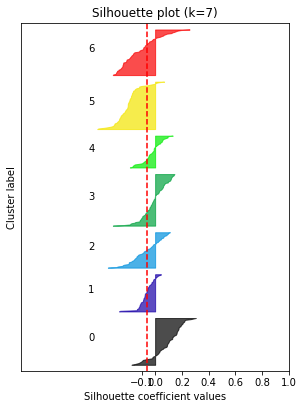

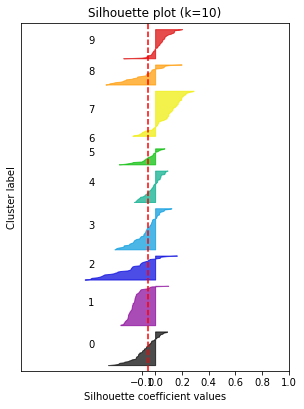

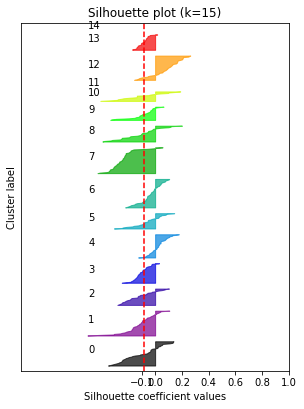

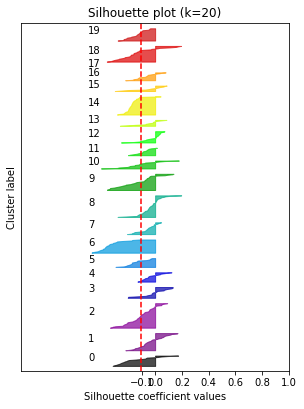

In [21]:
# Test the silhouette values curve
k_test = [7, 10, 15, 20]
sil_avgs, sil_arrs = silhouette_vals(x_train, k_test)

From Silhouette Analysis, it is clear that running k-Means on a dataset with 784 dimensions (specially flattened images), might not be a good idea. Almost every plot has a negative average silhouette coefficient (that is, most clusters are sparse), this means the the intra-cluster distances of points are lesser than inter-cluster distance. This could be because the distance metrics of euclidean distance on an image really does not make much sense (when it comes to grouping images). The following plots were obtained (different runs could give different results, based on the randomness of initialization) for the euclidean distance metric

- `k = 7`

    <img src="./figures/sil_k7.png" alt="k = 7" width=300 style="background-color: #ffffff" />

- `k = 10`

    <img src="./figures/sil_k10.png" alt="k = 10" width=300 style="background-color: #ffffff" />

- `k = 15`

    <img src="./figures/sil_k15.png" alt="k = 15" width=300 style="background-color: #ffffff" />

- `k = 20`

    <img src="./figures/sil_k20.png" alt="k = 20" width=300 style="background-color: #ffffff" />


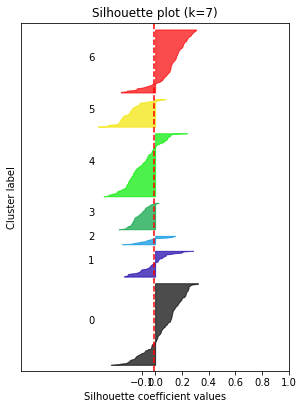

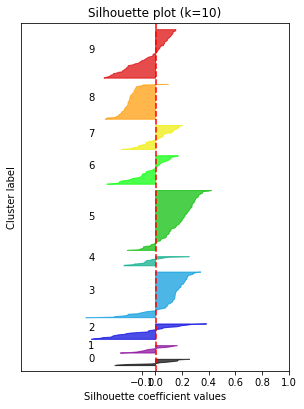

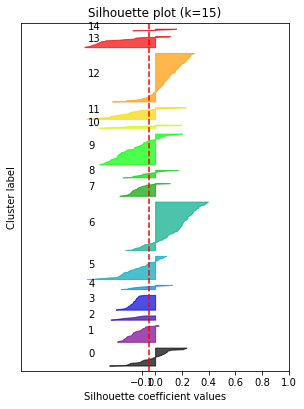

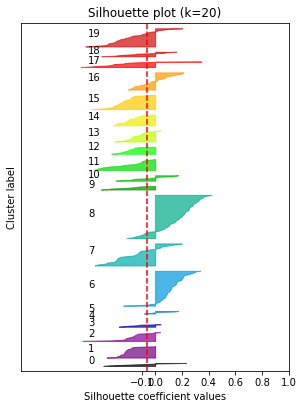

In [22]:
# Test the silhouette values curve
k_test = [7, 10, 15, 20]
sil_avgs, sil_arrs = silhouette_vals(x_train, k_test, dm="mt")

The situation under manhattan distance is far better. Maybe it's because manhattan distance is better for images. Here, the `k = 10` seems the best choice (highest average silhouette coefficient). The plots are shown below

- `k = 7`

    <img src="./figures/sil_mt_k7.png" alt="k = 7" width=300 style="background-color: #ffffff" />

- `k = 10`

    <img src="./figures/sil_mt_k10.png" alt="k = 10" width=300 style="background-color: #ffffff" />

- `k = 15`

    <img src="./figures/sil_mt_k15.png" alt="k = 15" width=300 style="background-color: #ffffff" />

- `k = 20`

    <img src="./figures/sil_mt_k20.png" alt="k = 20" width=300 style="background-color: #ffffff" />


In [25]:
print(f"Manhattan distance: best k = {k_test[np.argmax(sil_avgs)]}")

Manhattan distance: best k = 10


## Section 1.3: Visualize using tSNE

The following is covered

1. Visualizing the dataset and the clustering result using tSNE
2. Describing the result of the clustering through tSNE

In [26]:
# Convert the x_train to 2D embedding
x_in = x_train
x_out = TSNE(n_components=2, learning_rate='auto',init='random').\
    fit_transform(x_in)
# Markers for labels: https://matplotlib.org/stable/api/markers_api.html
y_m = {
    0: "o", 1: "v", 2: "^", 3: "<", 4: ">", 5: "1", 6: "2", 7: "3",
    8: "4", 9: "s"
}
# Dictionary
y_dct = dict()
# Fill the dictionary
for x, y in zip(x_out, y_train):
    if y not in y_dct:
        y_dct[y] = [x]
    else:
        y_dct[y].append(x)

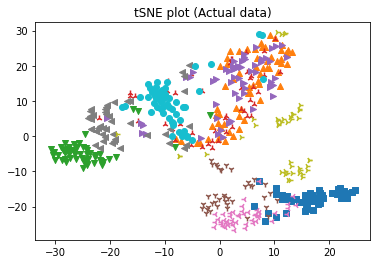

In [27]:
# Main tSNE plot
plt.figure()
plt.title("tSNE plot (Actual data)")
for y_c in y_dct:
    x_d = np.array(y_dct[y_c])    # Data points
    plt.scatter(x_d[:, 0], x_d[:, 1], marker=y_m[y_c])
plt.show()

In [28]:
# kMeans clustering (k = 10), manhattan distance, random part. init
km_cl = KMeans(10, "mt", "rp")
cga = km_cl.fit(x_train)
# Dictionary
y_dct = dict()
# Fill the dictionary
for x, y in zip(x_out, cga):
    if y not in y_dct:
        y_dct[y] = [x]
    else:
        y_dct[y].append(x)

[Iter 30]: Cluster centers stagnated


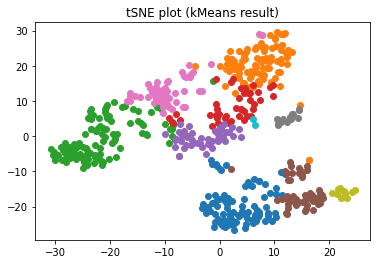

In [30]:
# Main tSNE plot - KMeans data
plt.figure()
plt.title("tSNE plot (kMeans result)")
for y_c in y_dct:
    x_d = np.array(y_dct[y_c])    # Data points
    plt.scatter(x_d[:, 0], x_d[:, 1])
plt.show()

Observing the tSNE plots, we can make the following comparison.

- tSNE output for actual data

    <img src="./figures/tsne_data.png" alt="tSNE actual" width=450 style="background-color: #ffffff" />

- tSNE output for kMeans result

    <img src="./figures/tsne_kmeans.png" alt="tSNE kMeans" width=450 style="background-color: #ffffff" />

> Note: Refer to the [marker styles](https://matplotlib.org/stable/api/markers_api.html) and the label classes from [tf.keras.fashion_mnist.load_data](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist/load_data)

The following inferences can be made

1. We can see that markers `v` and `<` (y = 1 and 3 - Trouser and Dress) are grouped as one. This is not surprising because a trouser is also a dress. However, most of circle markers `o` remain as a separate group, very well separated. This is the group of t-shirts/tops. This means that they're well separated from the group of dresses and trousers.
2. Markers `^`, `>` and `2` (y = 2, 4 and 6 - Pullover, Coat and Shirt) have good overlap in the actual data. This could be because they really cannot be well distinguished (with high certainty) in a small image. kMeans has created three groups in the region, but they're more separated (not intermixed like in the original data). This could show that the method has detected 3 groups, but cannot well distinguish between the three.
3. Markers `4` and `1` (y = 8 and 5 - Bag and sandal) are well separated, and the kMeans output also has them as separate group. However, the group for sandals seems to be engulfing a large part of marker `3` (y = 7 - Sneaker). Maybe because the kMeans method found both to be footwear.
4. The kMeans output has some new group within the same markers `s` (y = 9 - Ankle boot). And a good part of this overlaps with the clustering for sandal. This could mean that the dataset has some ankle boots that look like sandals, or that the images in black and white look very similar.

In [ ]:
# Extra cell for rough work!

---

# Part 2: Agglomerative Hierarchical clustering on Fashion-MNIST dataset

In this task, you need to implement Hierarchical clustering (agglomerative) on the same dataset. You can use [scikit-learn](https://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering) for this.

1. Visualize a dendrogram and find out the optimal number of clusters with the help of Dendrogram. Explain the procedure.

2. Implement Hierarchical clustering using
    1. Single linkage
    2. Complete linkage

3. Visualize the clusters obtained using these linkages and compare the results

In [34]:
# Import the packages
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

### Section 2.1: Clustering and Dendrogram

This section covers the following

1. Implementing agglomerative hierarchical clustering using [sklearn.cluster.AgglomerativeClustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering) and creating a dendrogram visualizer using [scipy.cluster.hierarchy.dendrogram](https://docs.scipy.org/doc/scipy/reference/reference/generated/scipy.cluster.hierarchy.dendrogram.html#scipy.cluster.hierarchy.dendrogram).
2. Visualizing and explaining a dendrogram.
3. Answering the question on procedure to find optimal number of clusters using dendrogram.

For visualization simplicity, a very small portion of the actual training set is used in this section (dendrogram can be more easily visualized)

In [88]:
# Agglomerative Clustering
x_small = x_train[:15]
agg_cls = AgglomerativeClustering(distance_threshold=2250, 
    n_clusters=None, linkage='single', compute_distances=True)
agg_fit = agg_cls.fit(x_small)

In [89]:
# Visualize Dendrogram
def viz_dendrogram(model, **kwargs):
    # Create linkage matrix
    c = np.zeros(model.children_.shape[0])  # Count of child items
    n_samples = model.labels_.shape[0]
    for i, merge in enumerate(model.children_):
        cc = 0  # Current count
        for c_idx in merge: # For each child item
            if c_idx < n_samples:
                cc += 1  # Leaf node
            else:
                cc += c[c_idx-n_samples]    # Parent
        c[i] = cc
    linkage_mat = np.column_stack([model.children_, model.distances_,
        c]).astype(float)
    # Plot the dendrogram
    dendrogram(linkage_mat, **kwargs)
    return linkage_mat

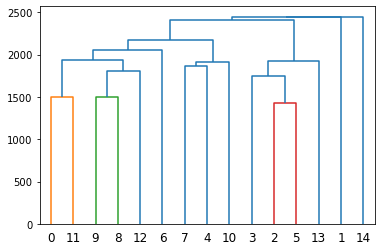

In [90]:
lmat = viz_dendrogram(agg_fit)

In [91]:
np.max(agg_fit.labels_)

3

As seen above, the dendrogram shows the process in which clusters are merging (bottom to top).

The two legs indicate which clusters were merged and the length of the two legs indicate the distance between the child clusters. The clusters with closer distance (according to the `linkage` parameter) merge sooner. The largest gap can be found at `2250` (approx), and that's why it was chosen as the threshold distance. It has 4 clusters (max = 3, so 0 to 3 are cluster labels), which we can see if we draw a horizontal line at `y = 2250` (it'll cut 4 legs, each showing the cluster group).

**Question**: Explain the procedure to find the optimal number of clusters using dendogram

**Answer**:

Once a big super-cluster is formed, the longest vertical distance without any horizontal line passing through in the dendrogram is found. This can be done by looking a empty spaces in the top. A horizontal line must be drawn through the legs of this _longest_ vertical distance (super-cluster merge). This is based on the idea that as the smaller clusters agglomerate, the distance between two different clusters now required (to merge as one) increases.

The number of clusters and the elements in those clusters correspond to the number of vertical lines this new horizontal line cuts _and_ the bottom-most leg items (could be found recursively) of these child / leg clusters respectively.


## Section 2.2: Experimenting with different linkages

This section covers the following

1. Implementing hierarchical clustering using `single` and `complete` linkages
2. Visualizing the results of this clustering (using tSNE algorithm, as done in the last section of part 1)
3. Answering the question on differences observed in the splits


In [99]:
# Visualisation of clusters using single linkage and complete linkage
agg_single = AgglomerativeClustering(10, linkage='single',
    compute_distances=True)
agg_complete = AgglomerativeClustering(10, linkage='complete',
    compute_distances=True)

In [100]:
# Fit the training set
as_fit = agg_single.fit(x_train)
ac_fit = agg_complete.fit(x_train)

### Dendrogram view

The dendrograms for finding the best `k`

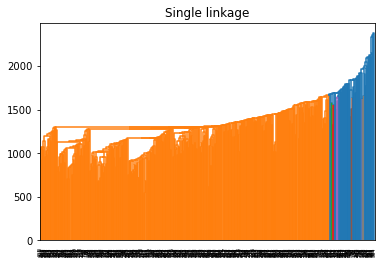

In [104]:
plt.title("Single linkage")
lmat = viz_dendrogram(as_fit)

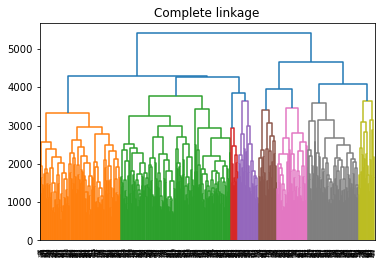

In [103]:
plt.title("Complete linkage")
lmat = viz_dendrogram(ac_fit)

**Question:** Mention the differences observed using single and complete linkage:

**Answer**:

The single linkage seems to merge often, this could be because it uses the smallest pairwise distance between two clusters (smallest dissimilarity). Hence, it might be a bad metric for this task (where there are very high number of dimensions). Its dendrogram is shown below

<img src="./figures/ddg_single.png" alt="Dendrogram Single Linkage" width=300 style="background-color: #ffffff" />

However, the complete linkage algorithm gives richer results. This could be because the complete linkage uses the _maximum_ pairwise distance (dissimilarity). Cutting the dendrogram at levels of 5000 will give `k = 2`, the best expected split. Its dendrogram is shown below

<img src="./figures/ddg_complete.png" alt="Dendrogram Complete Linkage" width=300 style="background-color: #ffffff" />

However, for this analysis, we'll let `k = 10` to see how the two methods have created clusters.

### tSNE Embedding

Visualizing everything using tSNE

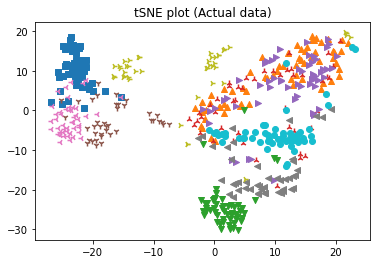

In [94]:
# Convert the x_train to 2D embedding
x_in = x_train
x_out = TSNE(n_components=2, learning_rate='auto',init='random').\
    fit_transform(x_in)
# Markers for labels: https://matplotlib.org/stable/api/markers_api.html
y_m = {
    0: "o", 1: "v", 2: "^", 3: "<", 4: ">", 5: "1", 6: "2", 7: "3",
    8: "4", 9: "s"
}
# Dictionary
y_dct = dict()
# Fill the dictionary
for x, y in zip(x_out, y_train):
    if y not in y_dct:
        y_dct[y] = [x]
    else:
        y_dct[y].append(x)
# Main tSNE plot
plt.figure()
plt.title("tSNE plot (Actual data)")
for y_c in y_dct:
    x_d = np.array(y_dct[y_c])    # Data points
    plt.scatter(x_d[:, 0], x_d[:, 1], marker=y_m[y_c])
plt.show()

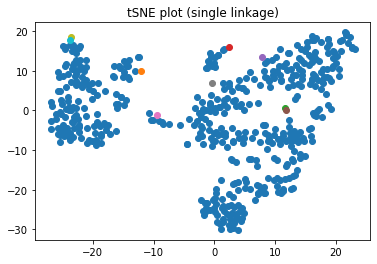

In [96]:
# Single linkage
cga = as_fit.labels_
# Dictionary
y_dct = dict()
# Fill the dictionary
for x, y in zip(x_out, cga):
    if y not in y_dct:
        y_dct[y] = [x]
    else:
        y_dct[y].append(x)
# Main tSNE plot - single linkage
plt.figure()
plt.title("tSNE plot (single linkage)")
for y_c in y_dct:
    x_d = np.array(y_dct[y_c])    # Data points
    plt.scatter(x_d[:, 0], x_d[:, 1])

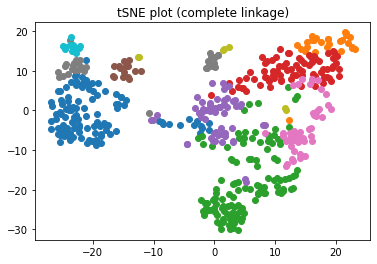

In [105]:
# Complete linkage
cga = ac_fit.labels_
# Dictionary
y_dct = dict()
# Fill the dictionary
for x, y in zip(x_out, cga):
    if y not in y_dct:
        y_dct[y] = [x]
    else:
        y_dct[y].append(x)
# Main tSNE plot - complete linkage
plt.figure()
plt.title("tSNE plot (complete linkage)")
for y_c in y_dct:
    x_d = np.array(y_dct[y_c])    # Data points
    plt.scatter(x_d[:, 0], x_d[:, 1])

As seen through the tSNE plots (note that the transpose of the figure makes no difference), we get the following images

- tSNE output for actual data

    <img src="./figures/tsne_data2.png" alt="tSNE of actual data" width=300 style="background-color: #ffffff" />

- tSNE output for single linkage

    <img src="./figures/tsne_s.png" alt="tSNE of single linkage" width=300 style="background-color: #ffffff" />

- tSNE output for complete linkage

    <img src="./figures/tsne_c.png" alt="tSNE of complete linkage" width=300 style="background-color: #ffffff" />

> Note: Refer to the [marker styles](https://matplotlib.org/stable/api/markers_api.html) and the label classes from [tf.keras.fashion_mnist.load_data](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist/load_data)

The following inferences can be made

- The single linkage didn't do a good job: it merged clusters too quickly, creating a giant super-cluster of sorts and leaving a few data-points in other clusters. This is not at all desired. In contrast the complete linkage has done a pretty good job of finding clusters. This is comparable (if not better) than the kMeans output we obtained earlier.
- The markers `s`, `4` and `3` (y = 9, 8 and 7 - Ankle boot, bag and sneaker) are segmented better into different clusters than the kMeans case. However, even this method seems to have combined a lot of `3` and `1` markers (sneakers and sandals). This could mean that they actually are difficult to distinguish in the dataset (at least the sample that we chose).
- Markers `^`, `>` and `2` (y = 2, 4 and 6 - Pullover, Coat and Shirt) have good overlap in the actual data. This is better illustrated by complete linkage agglomerative clustering than through kMeans (notice the better overlap among more classes in the tSNE of complete linkage, compared to the tSNE of kMeans). However, it also has fallen in some pitfalls (which kMeans also suffered). The markers `v` and `<` (y = trouser and dress) for example, are again merged into (more-or-less) the same cluster.

In [ ]:
# Space for some rough work!